In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import scvelo as scv

In [2]:
scv.logging.print_version()

Running scvelo 0.2.3 (python 3.6.13) on 2021-04-06 11:28.


In [32]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

## 0. Load the Data

In [4]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

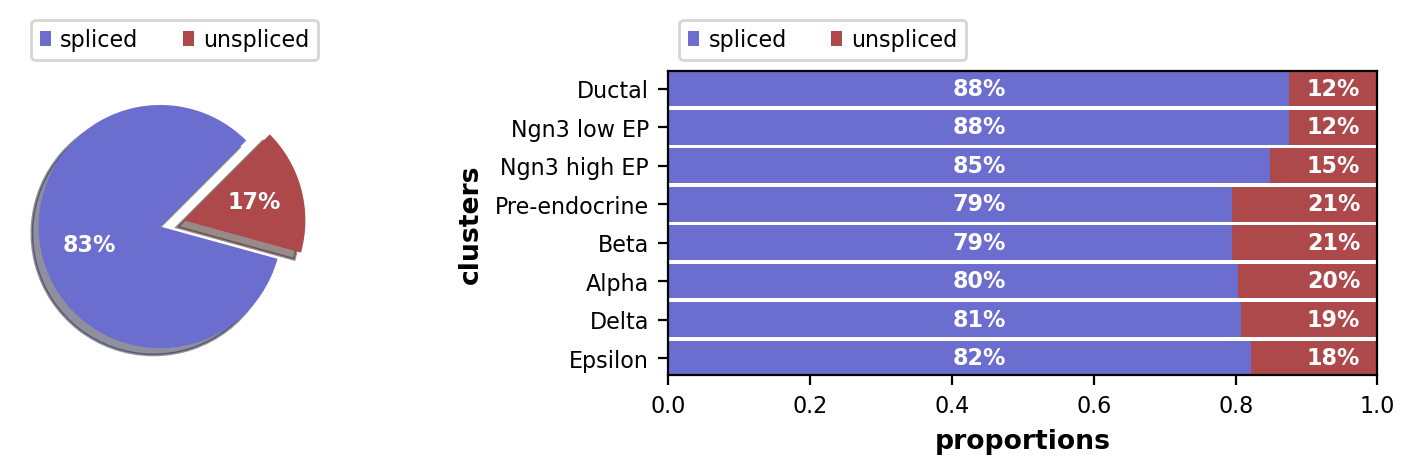

In [5]:
scv.pl.proportions(adata)

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [7]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30, method = "sklearn")

computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
#Estimate RNA velocity
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [9]:
#Estimate Transition Matrix
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
scv.tl.velocity_embedding(adata)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


## 1. Dynamical Model

In [11]:
scv.tl.recover_dynamics(adata, n_jobs = 10)

recovering dynamics (using 10/16 cores)


  0%|          | 0/1038 [00:00<?, ?gene/s]

    finished (0:01:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [12]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_stream_velocity.png


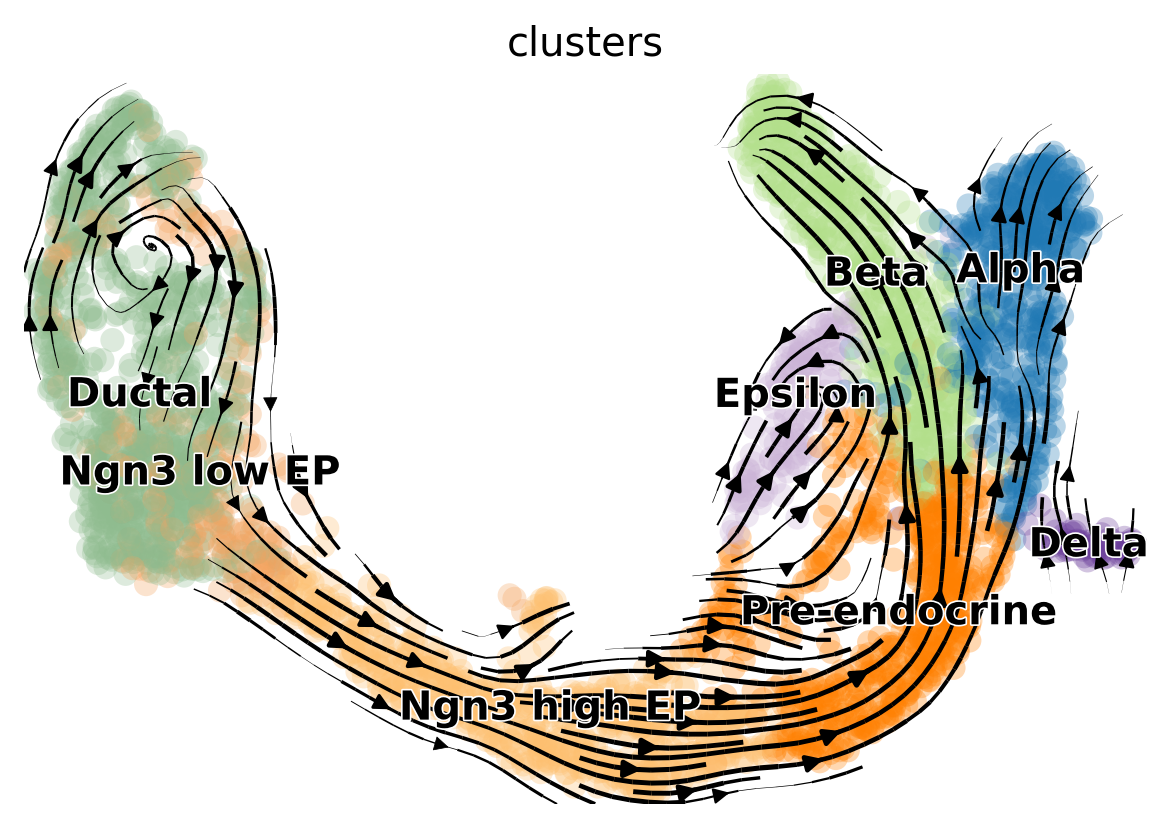

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='umap', dpi=120, save='stream_velocity.png')

saving figure to file ./figures/scvelo_graph_velocity.png


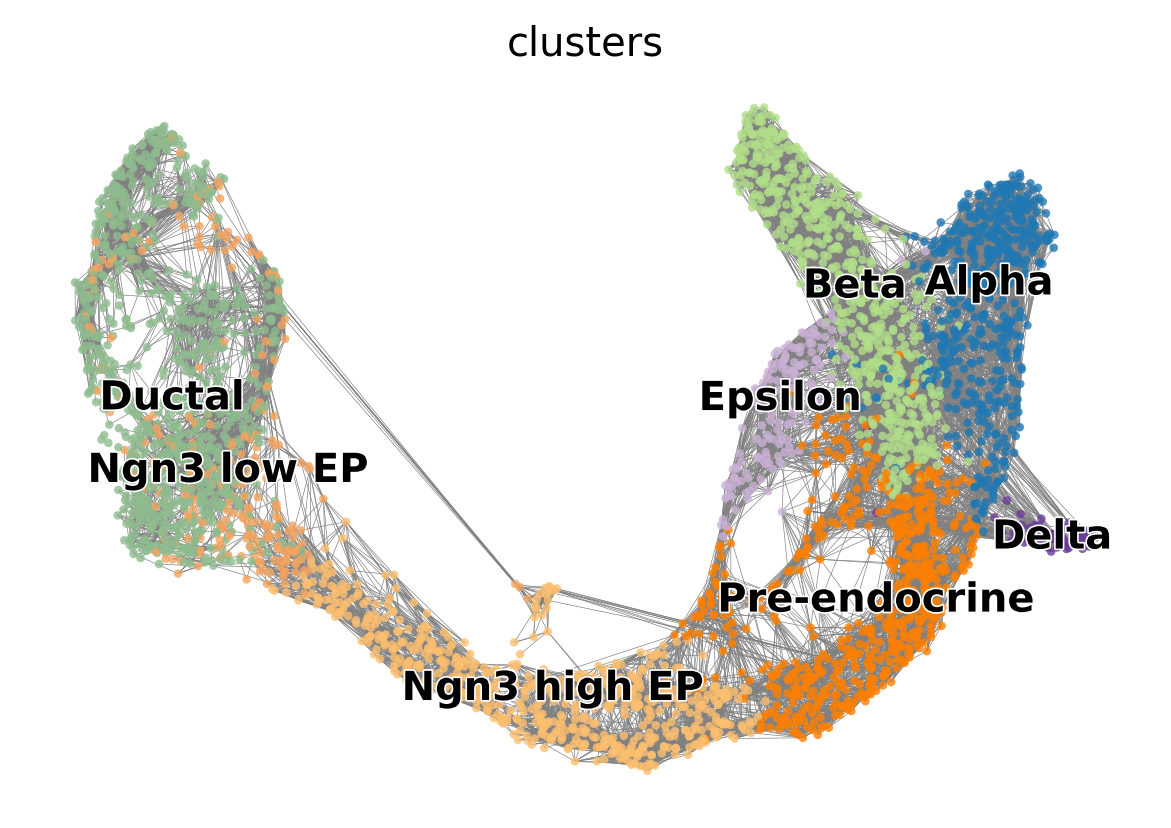

In [14]:
scv.pl.velocity_graph(adata, threshold=.1, dpi=120, save='graph_velocity.png')

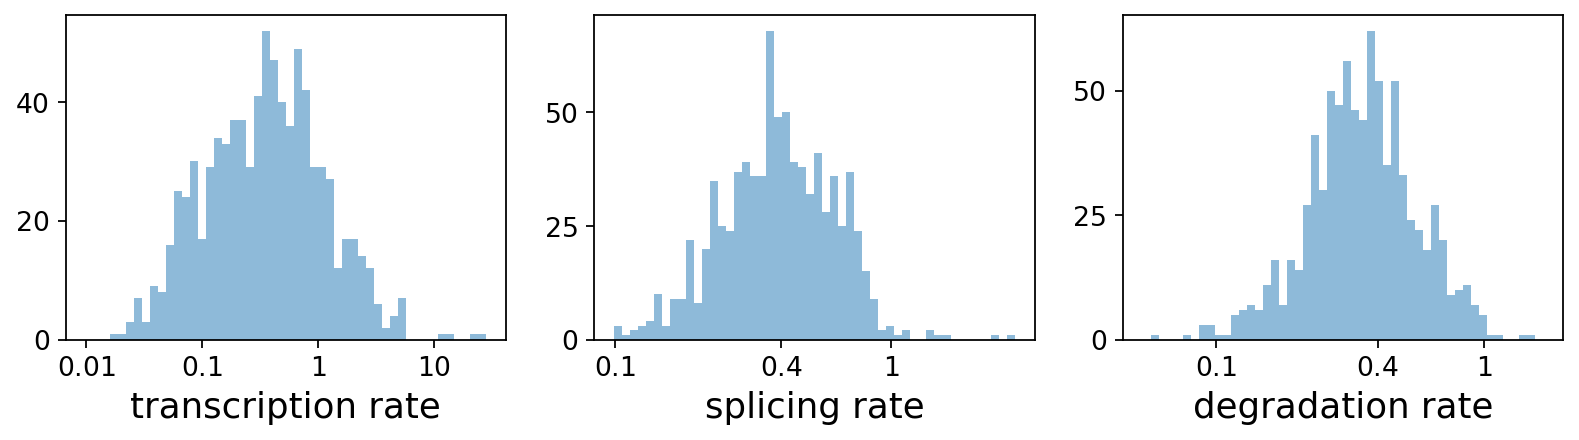

fit_alpha   fit_beta  fit_gamma     fit_t_  fit_scaling  fit_std_u  \
index                                                                         
Sntg1     0.015726   0.005592   0.088792  23.404254    42.849447   1.029644   
Sbspon    0.464865   2.437113   0.379645   3.785993     0.154771   0.058587   
Mcm3      3.096367  39.995796   0.638543   2.049463     0.013943   0.016253   
Fam135a   0.172335   0.118088   0.204538  11.239574     1.124040   0.356525   
Adgrb3    0.046828   0.006750   0.196856   6.992542    71.850736   2.153206   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
index                                                                 
Sntg1     0.030838        0.406523     0.0     0.0         0.159472   
Sbspon    0.178859        0.252135     0.0     0.0         0.182088   
Mcm3      0.673142        0.228207     0.0     0.0         0.467683   
Fam135a   0.149868        0.283343     0.0     0.0         0.387921   
Adgrb3    0.030417        0.250195     0.0     0.0         0.068851   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
index                                                                      
Sntg1        2.470675      0.094304      0.149138               5.355590   
Sbspon       0.164805      0.430623      0.674312               1.193015   
Mcm3         0.051432      1.927742      0.687468               0.887607   
Fam135a      1.345830      0.393197      0.671096               3.390194   
Adgrb3       5.214500      0.093570      0.556878               1.893389   

           fit_r2  
index              
Sntg1    0.401981  
Sbspon   0.624803  
Mcm3     0.292389  
Fam135a  0.384662  
Adgrb3   0.384552

In [15]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

The estimated gene-specific parameters comprise rates of transription (fit_alpha), splicing (fit_beta), degradation (fit_gamma), switching time point (fit_t_), a scaling parameter to adjust for under-represented unspliced reads (fit_scaling), standard deviation of unspliced and spliced reads (fit_std_u, fit_std_s), the gene likelihood (fit_likelihood), inferred steady-state levels (fit_steady_u, fit_steady_s) with their corresponding p-values (fit_pval_steady_u, fit_pval_steady_s), the overall model variance (fit_variance), and a scaling factor to align the gene-wise latent times to a universal, gene-shared latent time (fit_alignment_scaling).

## 2. Latent Time

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


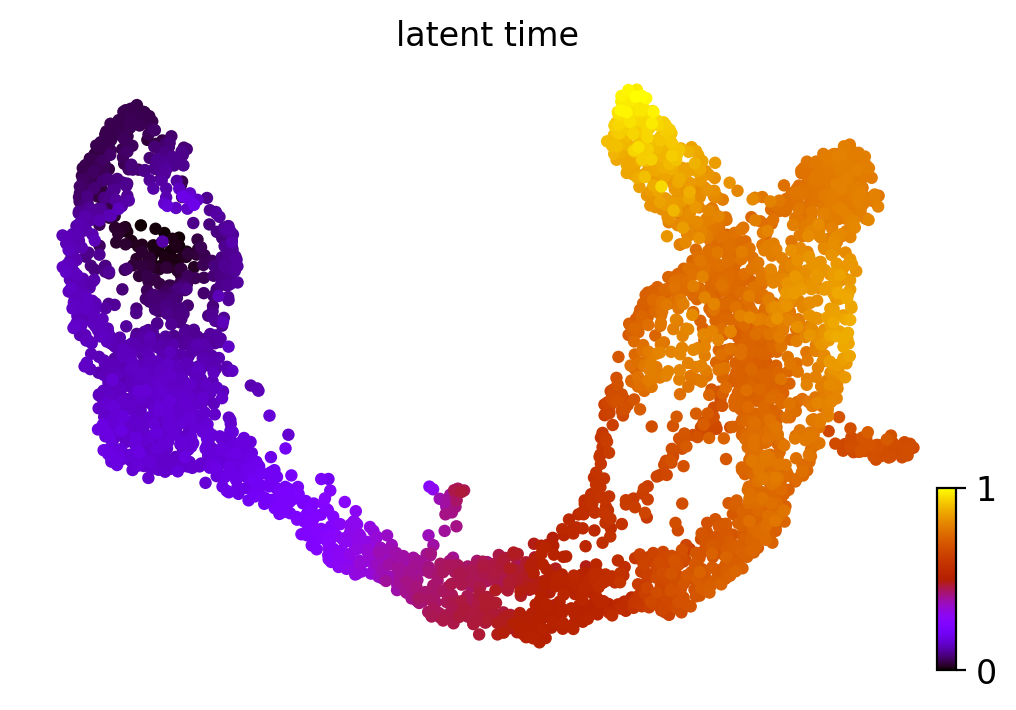

In [16]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

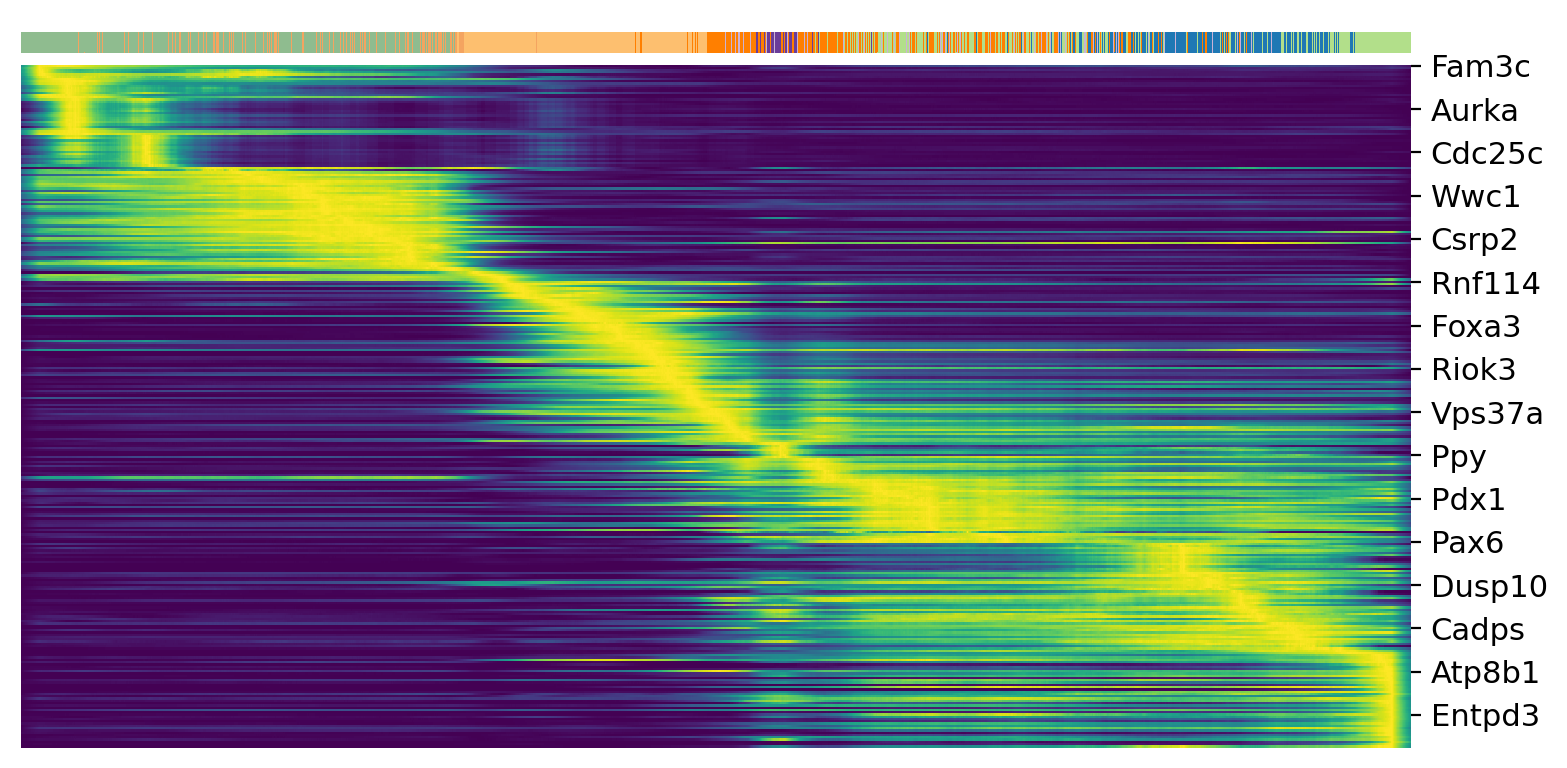

In [17]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

saving figure to file ./figures/scvelo_trajectory70_velocity.png


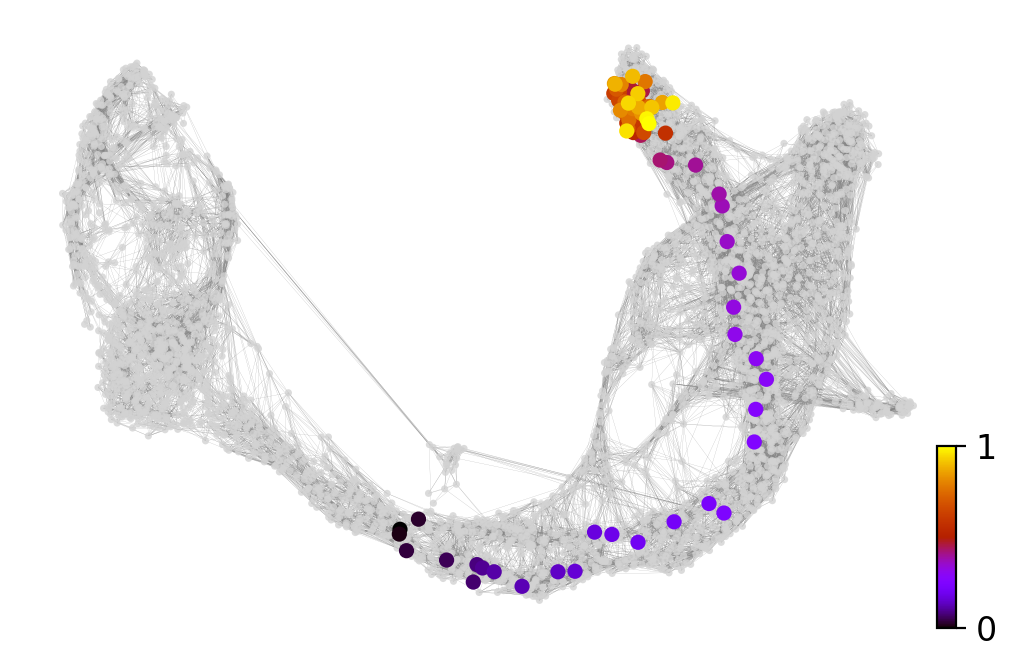

In [38]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70, random_state=27)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, save='trajectory70_velocity.png')

saving figure to file ./figures/scvelo_trajectory190_velocity.png


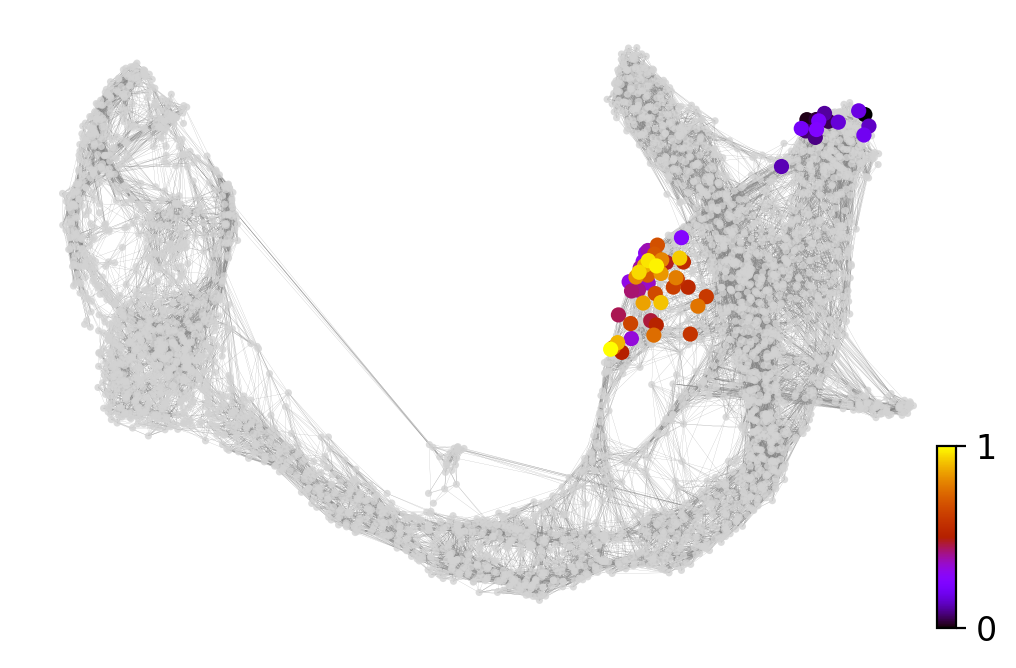

In [39]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=190, random_state=27)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, save='trajectory190_velocity.png')

saving figure to file ./figures/scvelo_trajectory2152_velocity.png


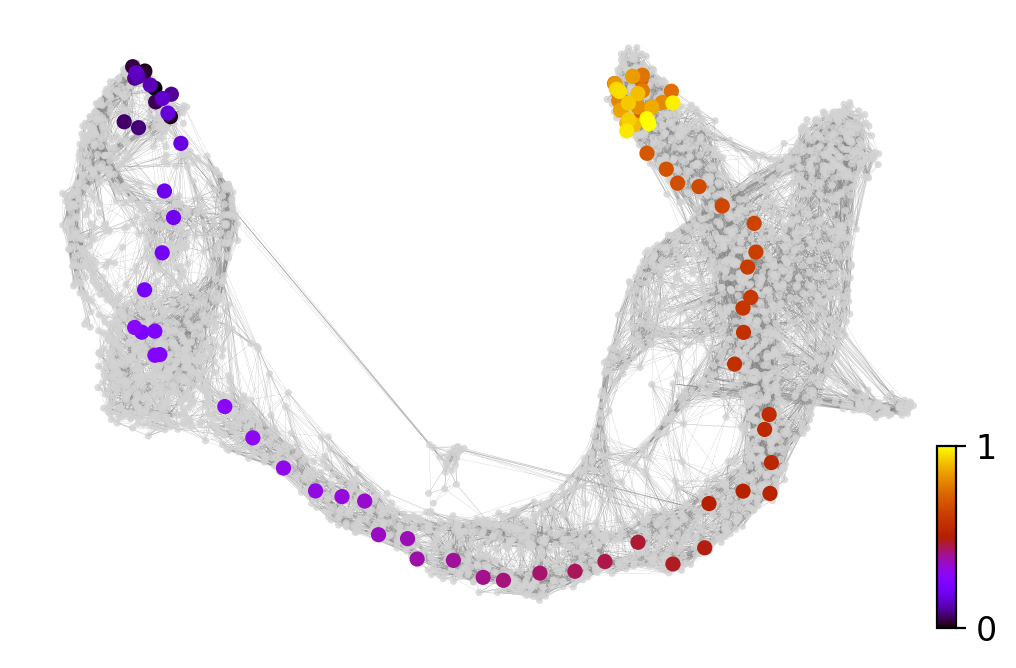

In [40]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=2152, random_state=27)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, save='trajectory2152_velocity.png')

saving figure to file ./figures/scvelo_trajectory3350_velocity.png


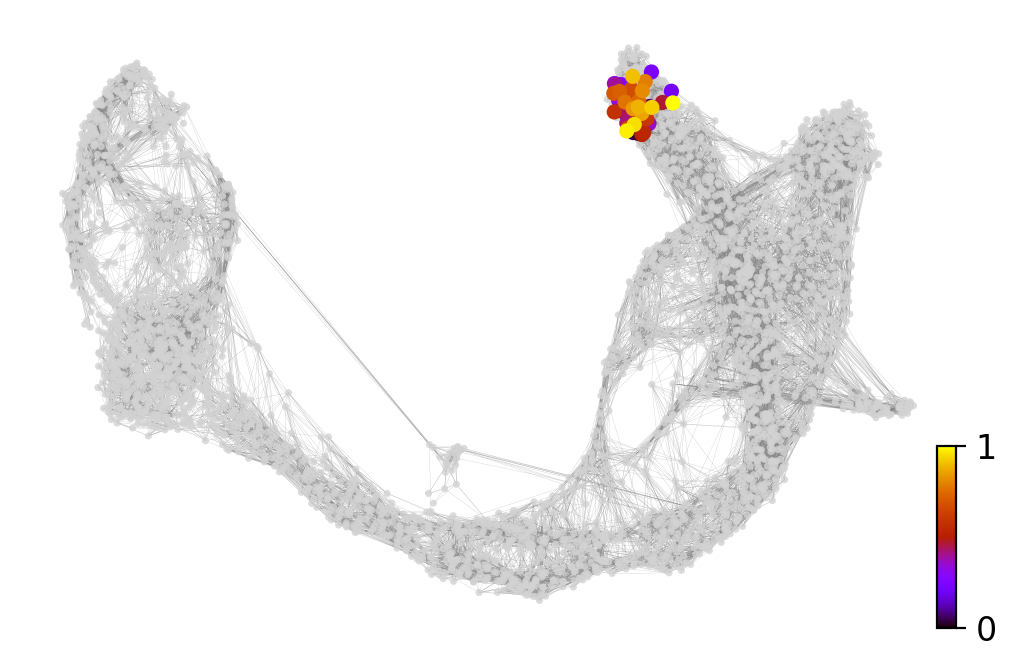

In [41]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=3350, random_state=27)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, save='trajectory3350_velocity.png')

## 3. Sankey Diagram and trajectories

In [42]:
from celloracle.trajectory.sankey import sankey
from celloracle.trajectory.oracle_core import _deal_with_na
from celloracle.trajectory.oracle_utility import _adata_to_color_dict

from scvelo.tools.transition_matrix import transition_matrix

In [43]:
#initial parameters for simulation (USER INPUT)
n_steps=100
n_duplication = 5
n_neighbors = 30

In [44]:
#prepare the indices
n_cells = adata.X.shape[0]
start_cell_id_array = np.repeat(np.arange(n_cells), n_duplication)

#prepare transition matrix
tr_matrix = transition_matrix(adata)
transition_prob = _deal_with_na(tr_matrix.toarray())
T = csr_matrix(transition_prob)
T.indices = tr_matrix.indices
T.indptr = tr_matrix.indptr

In [47]:
np.random.seed(1)
#compute trajectories
transitions = []
for i in start_cell_id_array:
    X = [i]
    for _ in range (n_steps):
        t = T[X[-1]]
        indices, p = t.indices, t.data
        idx = np.argsort(t.data)[::-1][:n_neighbors]
        indices, p = indices[idx], p[idx]
        p /=np.sum(p)
        ix = np.random.choice(indices, p = p)
        X.append(ix)
    transitions.append(X)
    
#results:
trajectory_df = pd.DataFrame(transitions)
trajectory_df.index = trajectory_df[0]

In [55]:
#prepare data for sankey diagram
mcmc_transition_cluster = pd.DataFrame(np.array(adata.obs['clusters'])[trajectory_df.values])
mcmc_color_dict = _adata_to_color_dict(adata, 'clusters')
df = mcmc_transition_cluster.iloc[:, [0, -1]]
df.columns = ["start", "end"]
order = ['Ductal','Ngn3 low EP', 'Ngn3 high EP','Pre-endocrine',
         'Delta','Epsilon','Alpha','Beta']

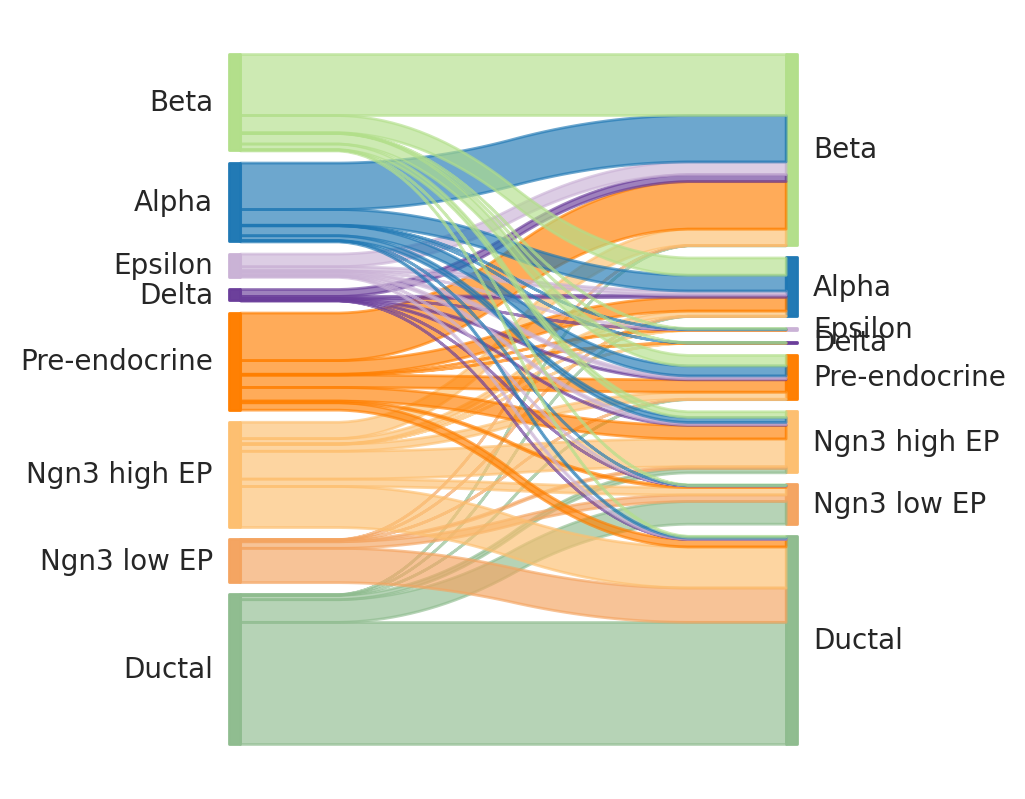

In [56]:
#sankey diagram
plt.figure(figsize=[4, 5])
sankey(left=df['start'], right=df['end'],
               aspect=1, fontsize=10,
               colorDict=mcmc_color_dict,
               leftLabels=order, rightLabels=order)

In [50]:
def _plot_one_trajectory(adata, trajectory_df, cell_ix_in_mcmctid, time_range, args={}, embedding = 'X_umap'):
        tt = trajectory_df.iloc[cell_ix_in_mcmctid,:].values[time_range]
        plt.plot(adata.obsm[embedding][:,0][tt], adata.obsm[embedding][:,1][tt], **args)

In [51]:
#plot trajectories
def plot_mc_result_as_trajectory(adata, trajectory_df, cell_name, time_range, args={}, embedding = 'X_umap'):
        """
        Pick up several timepoints in the cell state-transition simulation and plot as a line plot.
        This function can be used to visualize how cell-state changes after perturbation focusing on a specific cell.
        Args:
            cell_name (str): cell name. chose from adata.obs.index
            time_range (list of int): the list of index in Markov simulation
            args (dictionary): dictionary for the arguments for matplotlib.pyplit.plot.
                See matplotlib documentation for details (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot).
        """
        cell_ix = np.where(adata.obs.index == cell_name)[0][0]
        cell_ix_in_mcmctid = np.where(trajectory_df.index == cell_ix)[0]

        # plot all cells in gray color
        plt.scatter(adata.obsm[embedding][:,0], adata.obsm[embedding][:,1], s=1, c="lightgray")


        for i in cell_ix_in_mcmctid:
            _plot_one_trajectory(adata, trajectory_df, i, time_range, args)

        # plot cell of interest (initiation point of simulation) in red color
        plt.scatter(adata.obsm[embedding][cell_ix,0], adata.obsm[embedding][cell_ix,1], s=50, c="red")

cell AACCGCGAGGATGGTC
cell ACACCAAGTATAATGG
cell GATCGCGAGCTGAACG
cell TGCCCATGTGCCTGGT


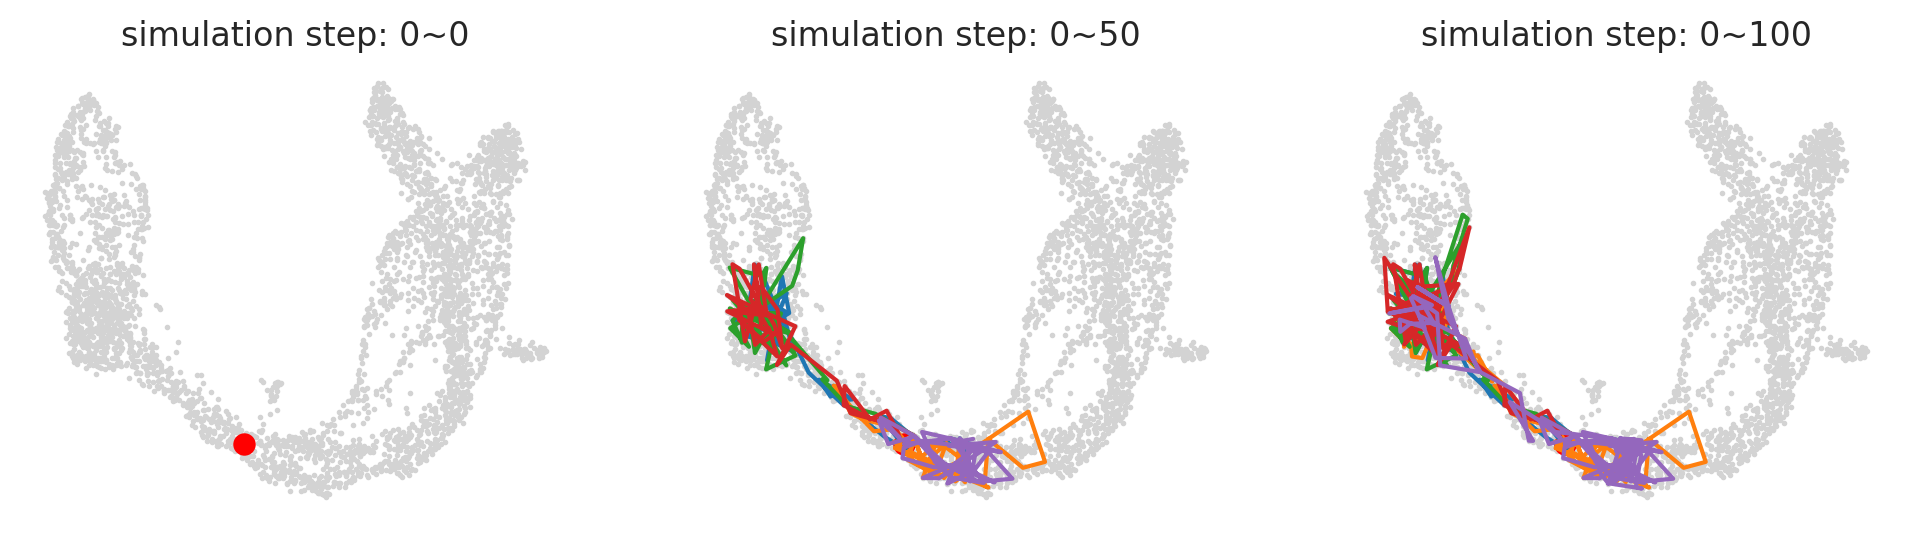

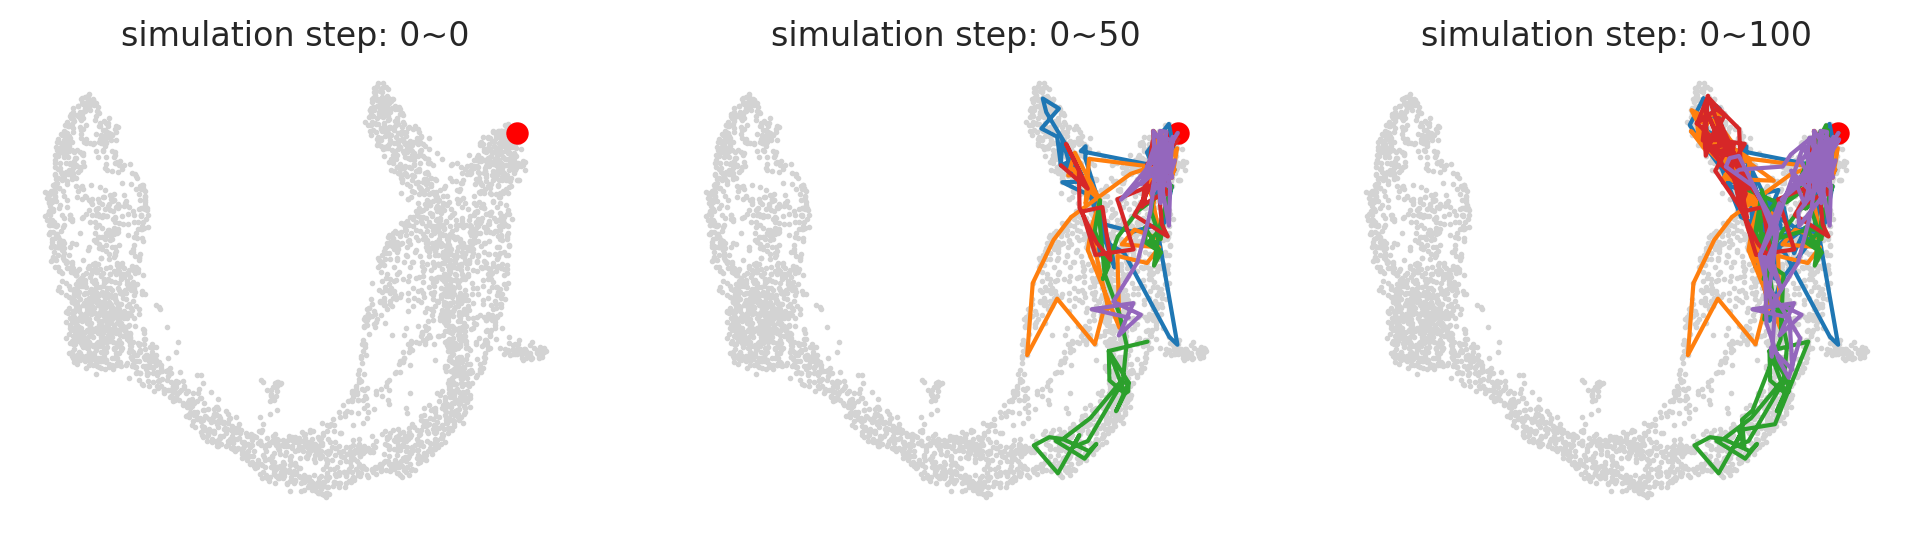

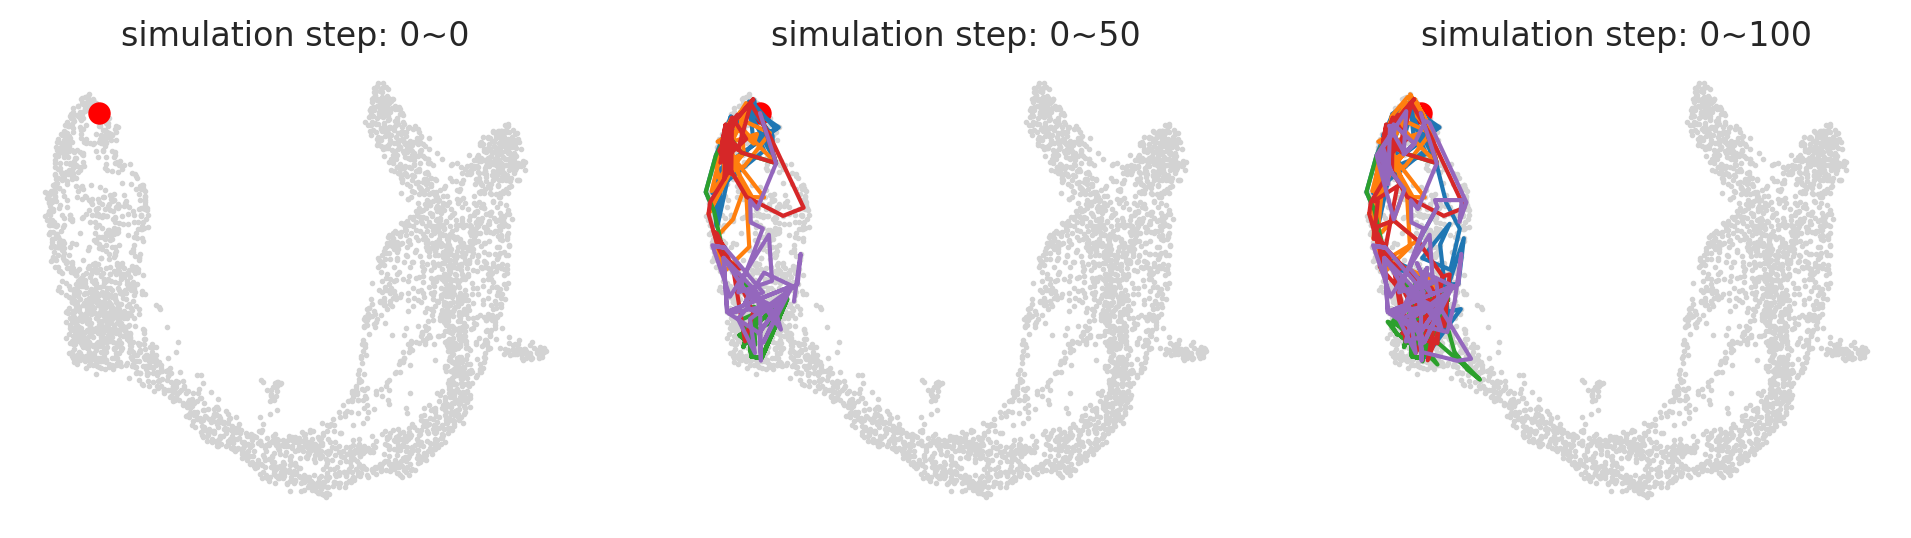

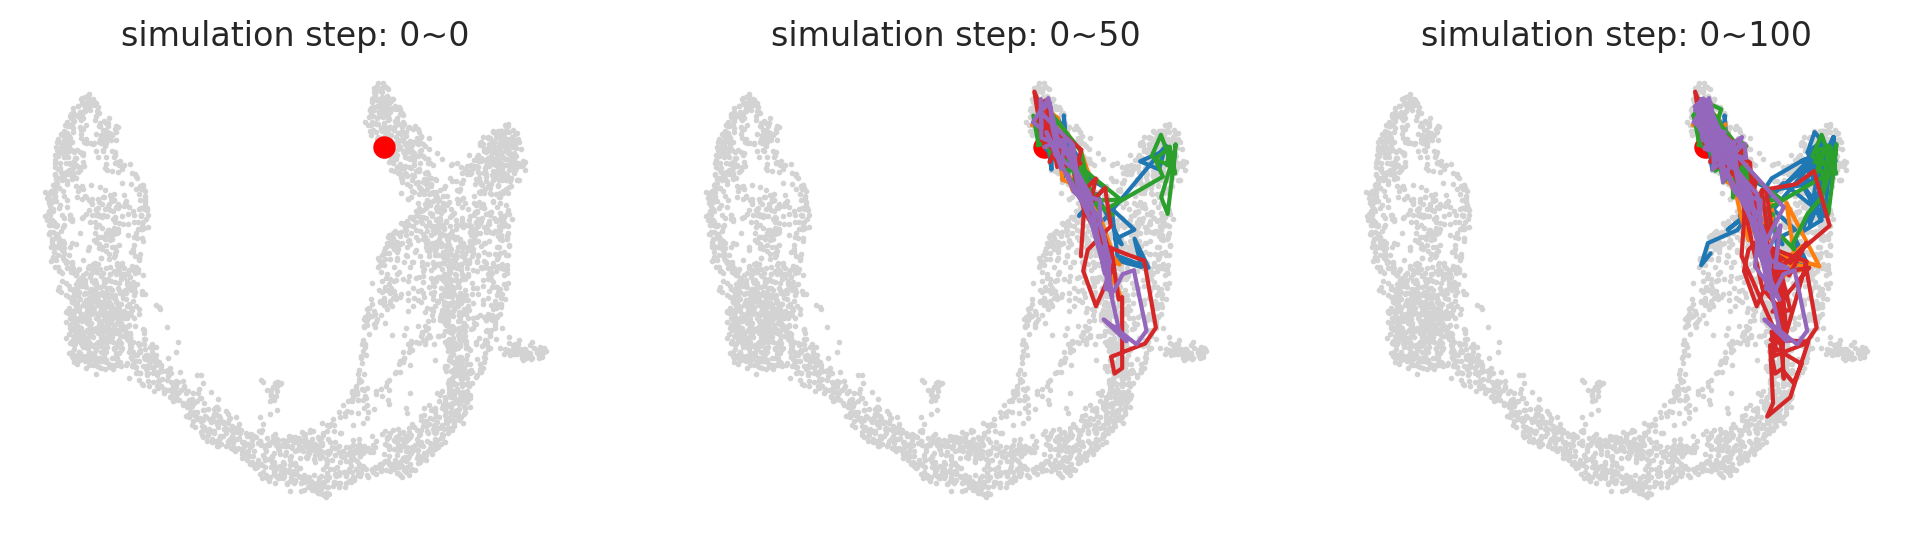

In [52]:
# Randomly pick up cells
np.random.seed(1)
cells = adata.obs.index.values[[70,190, 2152, 3350]]

# Visualize the simulated results of cell transition after perturbation
for k in cells:
    print(f"cell {k}")
    plt.figure(figsize=[12, 3])
    for j, i in enumerate([0, 50, 100]): # time points
        plt.subplot(1, 3, (j+1))
        plot_mc_result_as_trajectory(adata = adata, trajectory_df = trajectory_df, cell_name = k, time_range = range(0, i))
        plt.title(f"simulation step: 0~{i}")
        plt.axis("off")
    plt.show()

## GENES

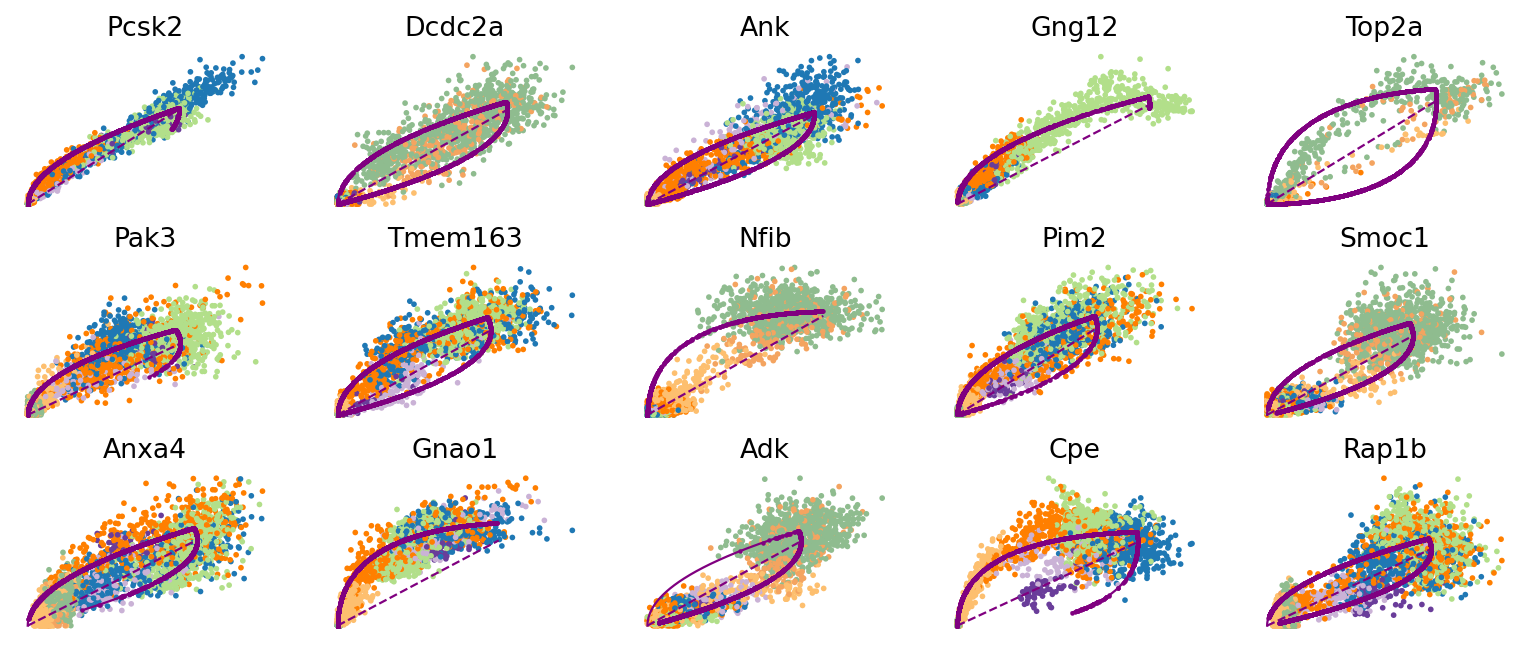

In [143]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

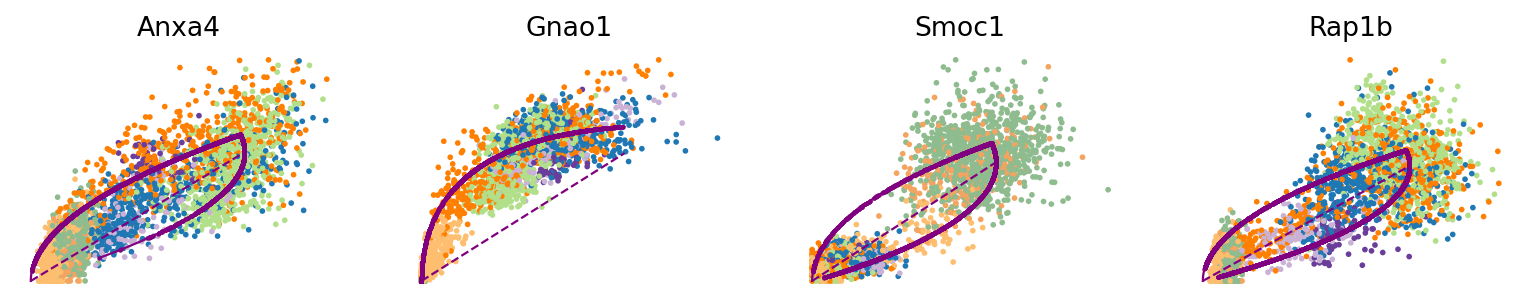

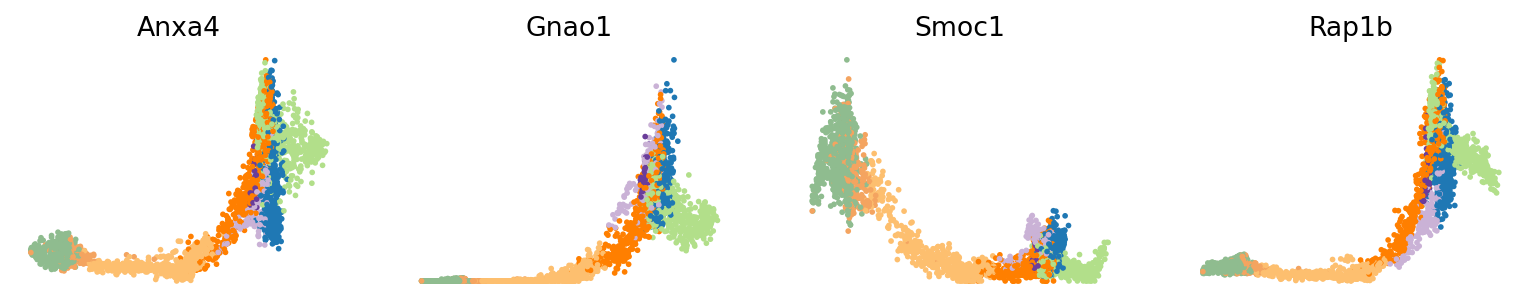

In [149]:
var_names = ['Anxa4', 'Gnao1', 'Smoc1', 'Rap1b']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

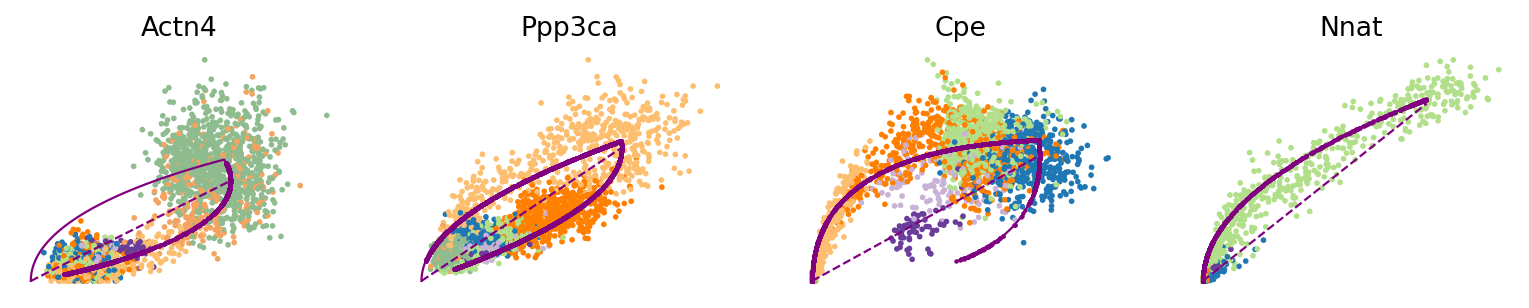

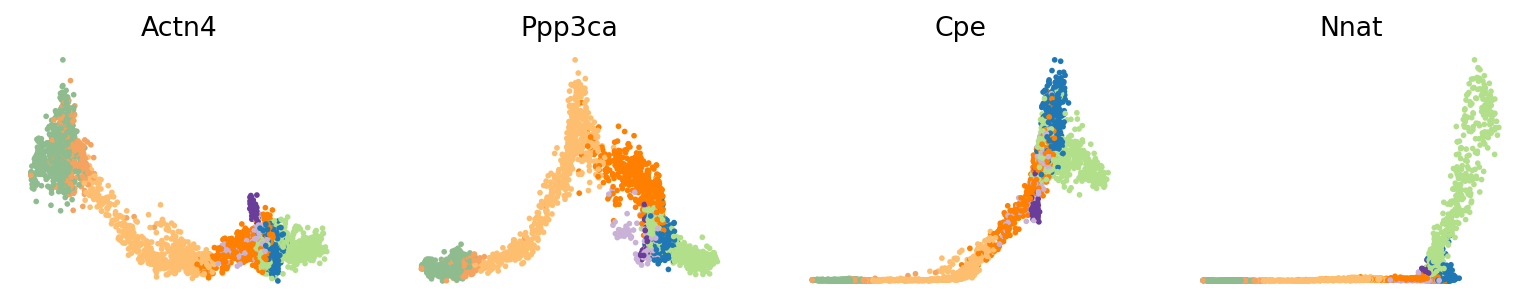

In [144]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)